In [1]:
## Import all necessary modules and set necessary directory paths

import matplotlib
%matplotlib inline
from sklearn.neighbors import KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import sys
import copy
import corner

from astropy.io import fits
from astropy.stats import bootstrap
from os.path import join, splitext
from scipy import special as spspec
from IPython.display import Image as im

from Wavefront import Image, Telescope, TELESCOPE_DICT
from Wavefront import wavecorr, waveplot, utils, wavefft

import generate_grids as gg
import gen_avg_per_unb as gapu
import cdr_create_parameters as ccp

pylab.rcParams['figure.figsize'] = 12, 8

main_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18'
data_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Data'
results_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Results'

In [34]:
## Choose a data file and telescope and create dictionary of file paths

data_file = 'ugp_When_2014.5.15_5.33.20_poldm_phase.fits'
telescope_name = 'GPI'
telescope = TELESCOPE_DICT[telescope_name]
pupil_mask = telescope.get_pupil((48,48), pix_scale=7.77/43)

path_dict = utils.filepath_library(data_file, main_directory, telescope_name)

path_dict.keys()

['avgZ_xi_dr_graph',
 'Zernikes',
 'Z_xi_dt_data',
 'xi_dr_graph',
 'xi_dt_data',
 'avgZ_image',
 'avgZ_xi_dr_data',
 'avg_res_xi_dr_graph',
 'Results',
 'Z_xi_dt_graph',
 'Graphs',
 'xi_dt_graph',
 'Base',
 'Images',
 'avg_res_xi_dr_data',
 'xi_dr_data',
 'Data']

In [36]:
## Build test data
image_list = Image.import_fits(path_dict['Data'])
image = image_list[4600]
image.mean_center(mask=pupil_mask)
image.data = image.data*2*np.pi/0.5

In [37]:
def psd(image_list, n=48, alpha_mag=0.99):
    
    if not isinstance(image_list, list):
        image_list = [image_list]
    if len(image_list) == 0:
        raise

    # Gemini parameters. Change to read from FITS header or HDF5 metadata
    bigD  = 7.770                   # primary diameter
    bigDs = 1.024                   # inner M2 is 1.024 m
    m     = 1.0                     # number of samples between actuators - usually 8.0
	# derived quantities
    bign      = n*m                 # width of phase screen for aperture
    nacross   = 43.0                # number of subaps across the pupil - latest GPI design is 43
	# for phase samples
    pscale    = bigD/((nacross)*m)  # pixel size (m) of samples in pupil plane
    d         = pscale*m            # subap diameter (m)

    perlen = 8.
    rate = 1000.
    
    cp_params = ccp.cdr_create_parameters(0)
    r0s       = cp_params[:,0]
    eff_r0    = (r0s**(-5./3.)).sum()**(-3./5.)

    phdim = image_list[0].data.shape 
    phx   = phdim[0]
    phy   = phdim[1]
    timesteps = len(image_list)

    ## Construct data from image_list
    data = np.zeros((timesteps, phx, phy))
    
    for n, image in enumerate(image_list):
        data[n,:,:] = image.data
                
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)

    #for t in np.arange(timesteps):
    # by default, the transform is computed over the last two axes
    # of the input array, i.e., a 2-dimensional FFT
    # phFT = np.fft.fft2(hdulist[0].data) / (phx*phy) #* freq_dom_scaling 
    for t in np.arange(timesteps):
        phFT[t,:,:] = np.fft.fft2(data[t,:,:]) / (phx*phy)
    
    mft = np.sum(phFT, axis=0)
        
    kx, ky = gg.generate_grids(phx, scalefac=2*np.pi/(bign*pscale), freqshift=True)
    kr = np.sqrt(kx**2 + ky**2)
    f = np.arange(perlen)
    omega = 2*np.pi*f/rate
    #shift array
    hz = np.roll(f-perlen/2, np.int(perlen/2))/perlen*rate
                
    this_psd = np.zeros((perlen, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            this_psd[:,k,l] = gapu.gen_avg_per_unb(phFT[:,k,l], perlen, meanrem=True)

    varpsd = np.sum(this_psd, axis=0)

    
    # Plot spatial PSD
    #print eff_r0
    
    plt.clf()
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(kr, varpsd, 'b.')
#    plt.plot(kr[:,1], 0.490*(eff_r0)**(-5./3.)*kr[:,1]**(-11./3.), 'r-')
    plt.ylim(1e-8,1e2)
    plt.xlim(1,200)
    plt.grid(True)

    return kr.flatten(), varpsd.flatten()

#    k = 4
#    l = 4
#    plt.clf()
#    plt.yscale('log')
#    plt.xlim(-200,200)
#    plt.plot(hz, this_psd[:,4,4]/np.abs(1-alpha_mag*np.exp(-1j*2*np.pi*hz/rate))**2)
    # 0.490*eff_r0**(-5./3.)*kr[4,4]**(-11./3.)/np.abs(1-alpha_mag*np.exp(-1j*2*np.pi*hz/rate))**2
#    plt.grid(True)
#    plt.show()

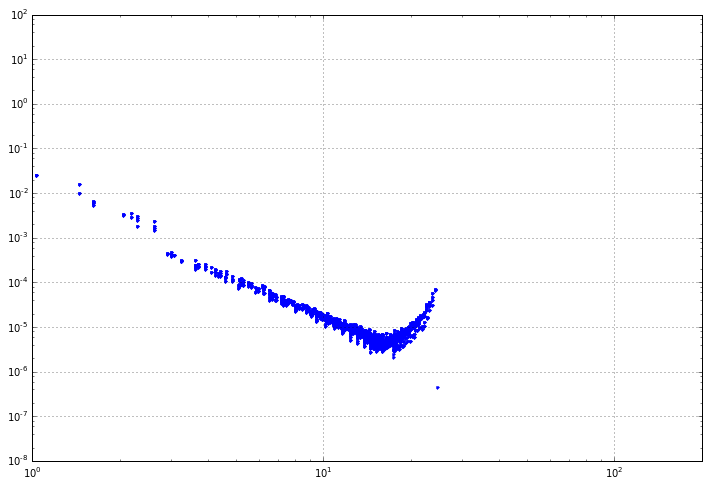

In [53]:
x, y = psd(image_list)

In [56]:
## Remove the spurious tail at high spatial order and kr=0 term

x = x[1:]
y = y[1:]

kr = x[x<10.5]
F = y[x<10.5]

#kr = x[1:]
#F = y[1:] 

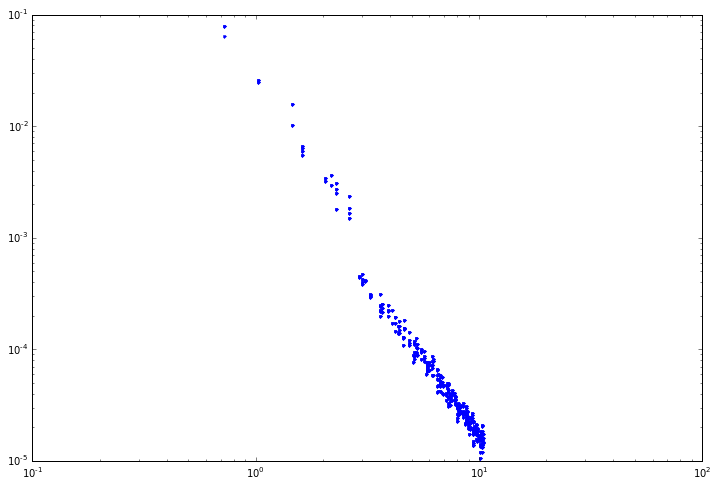

In [57]:
plt.yscale('log')
plt.xscale('log')
plt.plot(kr, F, 'b.')

In [58]:
par = np.polyfit(np.log10(kr), np.log10(F), 1)
slope = par[0]
intercept = par[1]

In [59]:
print slope, intercept

-3.10443839491 -1.71192524543


In [60]:
print np.exp(intercept)

0.180517916556


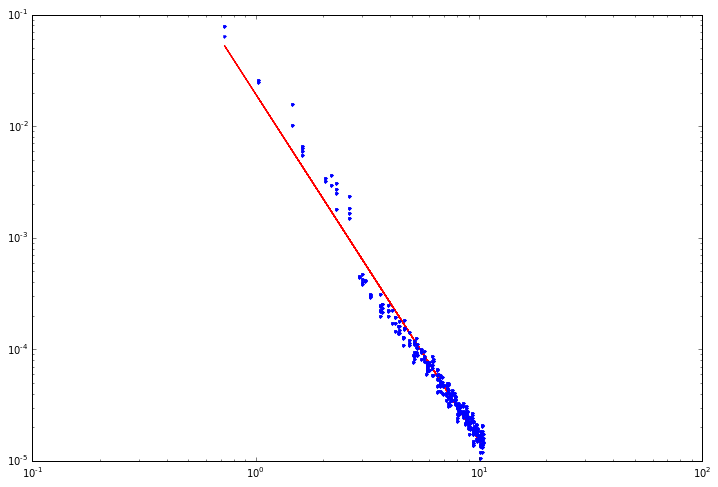

In [61]:
plt.loglog(kr, (10**intercept)*kr**slope, 'r',
         kr, F, 'b.')

3.6666666666666665